In [20]:
import pandas as pd

from collections import namedtuple
from datetime import datetime
from obspy import UTCDateTime

import catalog_lookup
from importlib import reload
reload(catalog_lookup)
%matplotlib inline

In [21]:
CATALOG_PATH = 'Benz_catalog.csv'
PREDICTION_PATH = 'predictions/ContinuousData/predictions(iterations-780416-total-99.07-class0-98.91-class1-99.37.pt-continuous_unlabeled_set).csv'

In [22]:
PREDICTED_TIMES = catalog_lookup.predicted_df(PREDICTION_PATH)

In [23]:
predicted_times = PREDICTED_TIMES.iloc[::2]
predicted_times.head()

,Time,Guess,True Label,event_start,event_end
243554,2014-07-01T00:00:05.005000Z--2014-07-01T00:00:...,0,0,2014-07-01T00:00:05.005000Z,2014-07-01T00:00:25.005000Z
568715,2014-07-01T00:00:15.005000Z--2014-07-01T00:00:...,0,0,2014-07-01T00:00:15.005000Z,2014-07-01T00:00:35.005000Z
960131,2014-07-01T00:00:25.005000Z--2014-07-01T00:00:...,0,0,2014-07-01T00:00:25.005000Z,2014-07-01T00:00:45.005000Z
25725,2014-07-01T00:00:35.005000Z--2014-07-01T00:00:...,0,0,2014-07-01T00:00:35.005000Z,2014-07-01T00:00:55.005000Z
450831,2014-07-01T00:00:45.005000Z--2014-07-01T00:01:...,0,0,2014-07-01T00:00:45.005000Z,2014-07-01T00:01:05.005000Z


In [24]:
to_string = lambda date: date.strftime('%m/%d/%Y')
predicted_times['Date'] = predicted_times['event_start'].map(lambda date: to_string(date))
start, end = predicted_times['Date'].iloc[0], predicted_times['Date'].iloc[-1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
catalog_times = catalog_lookup.catalog_df(CATALOG_PATH, start, end)

In [27]:
# Events predicted   
predicted_events = predicted_times[predicted_times['Guess'] == 1]
predicted_events = catalog_lookup.find_events_in_catalog(predicted_events, catalog_times)

In [28]:
pe_found = predicted_events[predicted_events['catalog_id'] != -1]

In [29]:
from itertools import chain

found_indexes = set(chain.from_iterable(pe_found['catalog_id']))   # Flatten list of lists
catalog_events = catalog_times.copy()
catalog_events['found'] = catalog_events.index.map(lambda i: i in found_indexes)

In [30]:
found = catalog_events[catalog_events['found'] == True]
missed = catalog_events[catalog_events['found'] == False]
_new = predicted_events[predicted_events['catalog_id'] == -1]

In [31]:
window_length = _new.iloc[0].event_end - _new.iloc[0].event_start
_new['time_diff'] = _new['event_start'].diff()
new = _new[_new['time_diff'] > window_length]       # Has to start one window after

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
len(found), len(missed), len(new)

(3859, 1878, 4006)

In [ ]:
new.head()

,Time,Guess,True Label,event_start,event_end,Date,timerange,catalog_id,time_diff
567670,2014-07-01T00:07:10.005000Z--2014-07-01T00:07:...,1,0,2014-07-01T00:07:10.005000Z,2014-07-01T00:07:30.005000Z,07/01/2014,"(2014-07-01T00:07:10.005000Z, 2014-07-01T00:07...",-1,305
23452,2014-07-01T00:07:45.005000Z--2014-07-01T00:08:...,1,0,2014-07-01T00:07:45.005000Z,2014-07-01T00:08:05.005000Z,07/01/2014,"(2014-07-01T00:07:45.005000Z, 2014-07-01T00:08...",-1,35
364409,2014-07-01T00:09:00.005000Z--2014-07-01T00:09:...,1,0,2014-07-01T00:09:00.005000Z,2014-07-01T00:09:20.005000Z,07/01/2014,"(2014-07-01T00:09:00.005000Z, 2014-07-01T00:09...",-1,75
670227,2014-07-01T00:18:40.005000Z--2014-07-01T00:19:...,1,0,2014-07-01T00:18:40.005000Z,2014-07-01T00:19:00.005000Z,07/01/2014,"(2014-07-01T00:18:40.005000Z, 2014-07-01T00:19...",-1,580
900219,2014-07-01T00:21:20.005000Z--2014-07-01T00:21:...,1,0,2014-07-01T00:21:20.005000Z,2014-07-01T00:21:40.005000Z,07/01/2014,"(2014-07-01T00:21:20.005000Z, 2014-07-01T00:21...",-1,160


# Visualizations

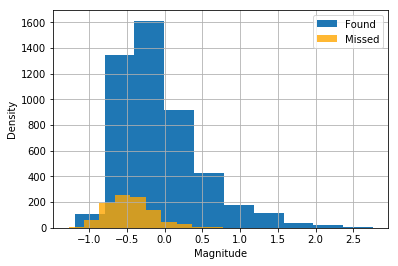

In [ ]:
import matplotlib.pyplot as plt

# Probability density function at the bin with "density=true"
ax = found.Magnitude.hist(label='Found')
missed.Magnitude.hist(fc=(1, .65, 0, 0.8), label='Missed')
ax.set(xlabel="Magnitude", ylabel="Density")
plt.legend()

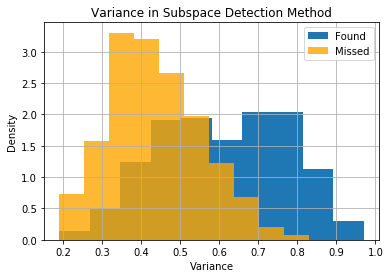

In [14]:
import matplotlib.pyplot as plt

found.Variance.hist(density=True, label='Found')
ax = missed.Variance.hist(density=True, fc=(1, .65, 0, 0.8), label='Missed')
ax.set(xlabel="Variance", ylabel="Density") 
plt.title("Variance in Subspace Detection Method")
plt.legend()

In [ ]:
start = found.iloc[0].Date
end = found.iloc[-1].Date

ax = found.Date.hist(label='Found', bins=31)
missed.Date.hist(fc=(1, .65, 0, .8), label='Missed', bins=31)
new.Date.hist(fc=(1, .2, .5, .3), label='New', bins=31)

ax.set(xlabel="Date", ylabel="Events Found") 
plt.legend()

ax = plt.gca() 
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = start
labels[-1] = end
ax.set_xticklabels(labels)

plt.show()

# Visualize New Events

In [ ]:
from utils import visualize

In [ ]:
import os
from pathlib import Path
import utils
reload(utils)

spectrograms_path = Path(os.getcwd()).parents[1] / 'parallel/spectrograms'
new['Filepath'] = new['Time'].map(lambda name: spectrograms_path / name)

In [ ]:
new.head()
len(new)

In [ ]:
new['Name'] = new['Time']
viz = visualize(new, show=10)

In [ ]:
next(viz)

# Visualize Missed Events

In [34]:
missed['Name'] = missed['Time']
viz = visualize(missed, show=10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
next(viz)

KeyError: 'Filepath'